# Gaia Catalog of Nearby Stars

Now lets examine the same process but w/ the galactic novae i prepped...

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [4]:
Novae = pd.read_csv('galnovae_ready.csv')
Novae

,ra,dec,dist,dist_err,mjd,name
0,268.749993,-21.378023,1416.983664,590.842181,59124.0,N Sgr 2020/4
1,260.924722,-31.052152,6519.523539,2412.031002,59100.0,N Sco 2020
2,59.623183,-54.778108,2703.087605,293.396771,59045.0,N Ret 2020
3,280.972502,0.063664,1884.066018,1251.734692,58981.0,N Aql 2020
4,269.058326,-20.716668,1726.948668,870.929269,58878.0,N Sgr 2020
...,...,...,...,...,...,...
273,239.875655,25.920222,806.363033,30.745869,2733.0,N CrB 1866
274,245.628245,-17.878690,6559.008285,2343.936764,1645.0,N Sco 1863
275,254.876540,-12.890884,804.655368,17.187193,-3856.0,N Oph 1848
276,119.747135,-43.822923,4161.394889,1647.111571,-67878.0,N Pup 1673


In [5]:
t0 = Time(Novae['mjd'].values, format='mjd')
c0 = SkyCoord(ra=Novae['ra']*u.deg, dec=Novae['dec']*u.deg, distance=Novae['dist']*u.pc)
# # SN 1987A Properties
# t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

# c0_radec = SkyCoord.from_name('SN 1987A')

# # Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
# d0 = 51.4 * u.kpc
# d0_err= 1.2 * u.kpc

# c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [148]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

# len(GCNS)
xyz = c1.transform_to(coord.Galactocentric)
Gaia_Err = (((GCNS['DIST_84'] - GCNS['DIST_50']) + (GCNS['DIST_50'] - GCNS['DIST_16']))/2 * u.kpc).to('lyr')

In [7]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year').shape

/Users/james/opt/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 105 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


(278,)

In [8]:
c = c0.distance.to('lyr') / 2 # dist to foci from ellipse center
c.shape

(278,)

In [9]:
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
a.shape

(278,)

In [11]:
d1 = c1.distance # dist to GCNS stars
d1.shape

(331312,)

In [32]:
# are any of the objects on the surface in the Alert database?
#   match to the gaia alerts databse
al = Table.read('Gaia_alerts.csv')
Cal = SkyCoord(ra=al['RaDeg']*u.deg, dec=al['DecDeg']*u.deg)

# print(len(al))
# al

In [46]:
tol = 0.1 # in lyr
nEYES = np.zeros(len(c0))
nOYES = np.zeros(len(c0))
nSNNO = np.zeros(len(c0))
nSNYES = np.zeros(len(c0))
source_ids = np.array([], dtype = GCNS['SOURCE_ID'].data.dtype)
source_IDX = np.array([])

# let's take the k'th Novae
for k in range(len(c0)):
# for k in [143]:
#     print(k)
    d2 = c1.separation_3d(c0[k]) # dist from GCNS to k'th Novae

    # d2.shape

    # 1. has it seen event yet?
    SNYES = d2.to('lyr').value <= ((c[k].to('lyr')*2) + (dt[k].to('s') * const.c)).to('lyr').value
    SNNO = ~SNYES

    # 2. is it within the "SETI ellipse"?
    EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a[k].to('lyr').value)
    ENO = ~EYES

    # 3. is it within some tolerance of being ON the ellipse?
    #    this could be within some range in distance or in time, thanks to speed of light...
    OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a[k].to('lyr').value)) <= tol

    # print( sum(OYES))
    nOYES[k] = sum(OYES)
    nEYES[k] = sum(EYES)
    nSNYES[k] = sum(SNYES)
    nSNNO[k] = sum(SNNO)
    source_ids = np.hstack((source_ids, GCNS['SOURCE_ID'][OYES].data))
    source_IDX = np.hstack((source_IDX, np.where(OYES)[0]))

    NAME = Novae['name'].astype('str').values[k]
    if (NAME == 'nan') | (NAME == '*'):
        NAME = str(t0.decimalyear[k])
    NAME = '-'.join(NAME.split('/'))
        
        
    if False:
        plt.figure(figsize=(10,10))
        plt.scatter(GCNS['XCOORD_50'][SNNO], GCNS['YCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
        plt.scatter(GCNS['XCOORD_50'][SNYES],GCNS['YCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
        plt.scatter(GCNS['XCOORD_50'][EYES], GCNS['YCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
        plt.scatter(GCNS['XCOORD_50'][OYES], GCNS['YCOORD_50'][OYES], c='k', s=10, 
                    alpha=0.75, rasterized=True, label='N='+str(sum(OYES)))

        plt.xlabel('X (pc)')
        plt.ylabel('Y (pc)')
#         plt.grid(True)
#         plt.title(NAME)
        plt.legend()
        plt.savefig(NAME+'.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)
        plt.close()
        
source_IDX = np.array(source_IDX, dtype=int)

# OK.. i'm cross matching something wrong here, since i'm getting the same distance and events, 
# but diff times.. the same star cant be the best match for that novae THAT often, right?

KeyboardInterrupt: 

2022.231014928425

In [180]:
Novae

,ra,dec,dist,dist_err,mjd,name
0,268.749993,-21.378023,1416.983664,590.842181,59124.0,N Sgr 2020/4
1,260.924722,-31.052152,6519.523539,2412.031002,59100.0,N Sco 2020
2,59.623183,-54.778108,2703.087605,293.396771,59045.0,N Ret 2020
3,280.972502,0.063664,1884.066018,1251.734692,58981.0,N Aql 2020
4,269.058326,-20.716668,1726.948668,870.929269,58878.0,N Sgr 2020
...,...,...,...,...,...,...
273,239.875655,25.920222,806.363033,30.745869,2733.0,N CrB 1866
274,245.628245,-17.878690,6559.008285,2343.936764,1645.0,N Sco 1863
275,254.876540,-12.890884,804.655368,17.187193,-3856.0,N Oph 1848
276,119.747135,-43.822923,4161.394889,1647.111571,-67878.0,N Pup 1673


In [189]:
tol = 0.1 # in lyr

# dt (from now) to the first alert (2014)
AL1 = (Time(al['Date'], format='iso')-t1).to('year').value.min()

acount = 0
# let's take the k'th Novae
for k in range(len(c0)):
    
    NAME = Novae['name'].astype('str').values[k]
    if (NAME == 'nan') | (NAME == '*'):
        NAME = str(t0.decimalyear[k])
    NAME = '-'.join(NAME.split('/'))

    d2 = c1.separation_3d(c0[k]) # dist from GCNS stars to k'th Novae        
 
    # from the GCNS_SN1987A_time notebook
    # ellipsoid crossing date for all GCNS stars and the k'th Novae
    etime = (d2.to('lyr') + d1.to('lyr') - (c0.distance[k].to('lyr'))).value + t0.decimalyear[k]
    
    # find GCNS ellipsoid crossings for the k'th Novae since 
    e7 = ((etime-t1.decimalyear >= AL1) & # the first alert
          (etime-t1.decimalyear < 0.1) # up to 0.1 years from now
         ) 
    # gather the GCNS stars that cross the k'th Novae ellipsoid since 2014
    CE7 = SkyCoord(ra=GCNS['RA'][e7]*u.deg, dec=GCNS['DEC'][e7]*u.deg)

    # cross match to the alerts
    idx, d2d, _ = CE7.match_to_catalog_sky(Cal)
    
    # any alerts within 1arcsec of any ellipsoid crossing stars?
    if (d2d.arcsec.min() < 1):
#         OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a[k].to('lyr').value)) <= tol
#         etime_yes = np.abs(etime-t1.decimalyear) < tol
#         print(sum(OYES), sum(etime_yes))

        l1 = d2d.arcsec < 1.
        for j in range(sum(l1)):
            # now lets apply some smarter cuts!
            #    dist error to source < 1 lyr AND
            #    alert date > ellipsoid crossing date (-0.3 yrs for good measure?)
            if ((Gaia_Err[e7][l1][j].value < 1) & # 
                (Time(al['Date'], format='iso')[idx][l1][j].decimalyear >= (etime[e7][l1][j]))
               ):
#                 print(k, NAME)
                print(NAME, c0.distance[k].to('lyr'),c0.ra[k].deg, c0.dec[k].deg,
                      GCNS['SOURCE_ID'][e7][l1][j], # gaia source ID
                      GCNS['RA'][e7][l1][j], GCNS['DEC'][e7][l1][j],
                      format((GCNS['DIST_50'][e7][l1][j]*u.kpc).to('lyr'),'10.5f'),
                      format(d2d.arcsec[l1][j] * u.arcsec, '6.4f'), # how close the alert is in (ra,dec) 
                      'etime:',
                      format(etime[e7][l1][j],'8.3f'), # the predicted ellipsoid crossing time for this source 
                      format(Gaia_Err[e7][l1][j], '7.4f'), # the distance error
                      al['#Name'][idx][l1][j], # the alert name
                      'Atime:',
                      format(Time(al['Date'], format='iso')[idx][l1][j].decimalyear, '8.3f'), # the alert date
#                       al['RaDeg'][idx][l1][j],al['DecDeg'][idx][l1][j],
                     )
                print()
                acount += 1
print(acount
     )

N Cen 2009 12300.088329212998 lyr 202.81569201578 -63.96065563007 5790825515237576064 200.6957141807385 -75.54316950687168  312.03653 lyr 0.2044 arcsec etime: 2015.890  0.3368 lyr Gaia20fhq Atime: 2020.879

N Cen 2008 12163.387743521549 lyr 218.76039559854 -64.10561023479 5790825515237576064 200.6957141807385 -75.54316950687168  312.03653 lyr 0.2044 arcsec etime: 2016.728  0.3368 lyr Gaia20fhq Atime: 2020.879

N Nor 2005 9448.950170899849 lyr 244.93657653939 -51.58114468431 6203171409633371520 222.01860550705896 -35.2089300483848  171.48256 lyr 0.3124 arcsec etime: 2019.266  0.2830 lyr Gaia19ekz Atime: 2019.750

2003.7698630136986 9981.742270512015 lyr 229.46877587369 -61.95428614858 5790825515237576064 200.6957141807385 -75.54316950687168  312.03653 lyr 0.2044 arcsec etime: 2017.445  0.3368 lyr Gaia20fhq Atime: 2020.879

N Cen 1995 9977.776678015523 lyr 195.6324928856 -60.19337737111 6203171409633371520 222.01860550705896 -35.2089300483848  171.48256 lyr 0.3124 arcsec etime: 2018.827 

In [186]:
c0.ra.deg

array([268.74999269, 260.92472236,  59.62318349, 280.97250211,
       269.05832621,  92.48938759, 264.64638275, 256.89239085,
       243.63722455, 234.68271273,  70.83904087, 159.05707497,
       255.94821406, 208.36493515, 171.56251482, 262.64219976,
       132.6233805 , 200.23055711, 232.25737631, 276.37442778,
       264.58052638, 263.96094157, 275.74703991, 270.88677063,
       262.30653321, 211.88032573, 273.6048311 , 255.85904926,
       305.42633636, 258.94530994, 313.59899033, 276.28653618,
       208.68885179, 272.26431559, 285.63884082, 305.87784125,
       347.01967499, 283.14540111, 275.11365286, 268.10746906,
       272.76540155, 216.27531612, 261.52920947, 205.28889475,
       162.58172283, 249.1844933 , 253.78940036, 272.58893067,
       268.26288561, 256.53133274, 264.92073301,  71.97586772,
       264.58212442, 271.78149149, 202.81569202, 266.03522424,
       275.50608065, 168.47399249, 199.15157335, 218.7603956 ,
       271.49536858, 295.7582219 , 244.70086327, 297.03

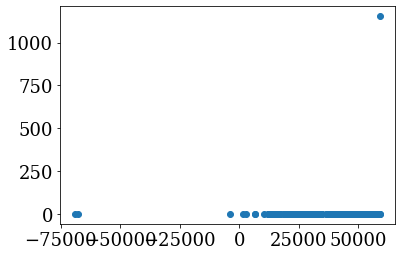

In [170]:
plt.scatter(Novae['mjd'], nEYES)

In [99]:
print(np.shape(source_ids), np.shape(np.unique(source_ids)))

(41180,) (36135,)


In [106]:
np.size(np.unique(source_ids)) / len(GCNS)

0.10906637851934128

In [108]:
GCNS.columns

<TableColumns names=('SOURCE_ID','RA','RA_ERROR','DEC','DEC_ERROR','PARALLAX','PARALLAX_ERROR','PMRA','PMRA_ERROR','PMDEC','PMDEC_ERROR','PHOT_G_MEAN_MAG','PHOT_G_MEAN_FLUX_OVER_ERROR','PHOT_BP_MEAN_MAG','PHOT_BP_MEAN_FLUX_OVER_ERROR','PHOT_RP_MEAN_MAG','PHOT_RP_MEAN_FLUX_OVER_ERROR','PHOT_BP_RP_EXCESS_FACTOR','RUWE','IPD_FRAC_MULTI_PEAK','ADOPTEDRV','ADOPTEDRV_ERROR','ADOPTEDRV_REFNAME','RADIAL_VELOCITY_IS_VALID','GCNS_PROB','WD_PROB','DIST_1','DIST_16','DIST_50','DIST_84','XCOORD_50','XCOORD_16','XCOORD_84','YCOORD_50','YCOORD_16','YCOORD_84','ZCOORD_50','ZCOORD_16','ZCOORD_84','UVEL_50','UVEL_16','UVEL_84','VVEL_50','VVEL_16','VVEL_84','WVEL_50','WVEL_16','WVEL_84','NAME_GUNN','REFNAME_GUNN','GMAG_GUNN','E_GMAG_GUNN','RMAG_GUNN','E_RMAG_GUNN','IMAG_GUNN','E_IMAG_GUNN','ZMAG_GUNN','E_ZMAG_GUNN','NAME_2MASS','J_M_2MASS','J_MSIG_2MASS','H_M_2MASS','H_MSIG_2MASS','K_M_2MASS','K_MSIG_2MASS','NAME_WISE','W1MPRO_PM_WISE','W1SIGMPRO_PM_WISE','W2MPRO_PM_WISE','W2SIGMPRO_PM_WISE','W3MPRO_WISE

Text(0, 0.5, '$M_{G}$')

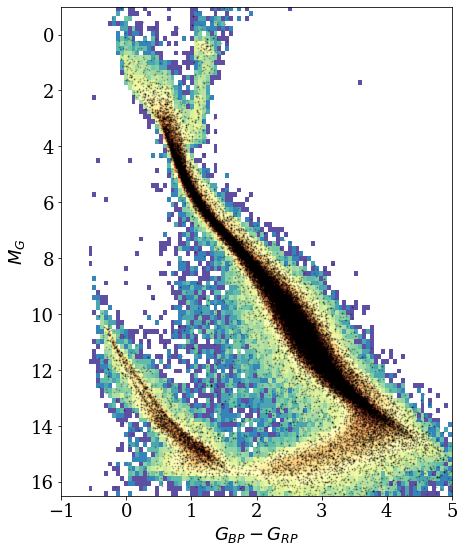

In [145]:
plt.figure(figsize=(7,9))
_ = plt.hist2d(GCNS['PHOT_BP_MEAN_MAG'] - GCNS['PHOT_RP_MEAN_MAG'], 
               GCNS['PHOT_G_MEAN_MAG'] - 5*np.log10(GCNS['DIST_50']*1000)+5, 
               range=[[-1,5],[-1,16.5]], bins=100, cmap=plt.cm.Spectral_r, norm=LogNorm())
plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][source_IDX] - GCNS['PHOT_RP_MEAN_MAG'][source_IDX], 
            GCNS['PHOT_G_MEAN_MAG'][source_IDX] - 5*np.log10(GCNS['DIST_50'][source_IDX]*1000)+5,
            s=1, c='k', alpha=0.2)
# plt.scatter()
plt.gca().invert_yaxis()
plt.xlabel(r'$G_{BP} - G_{RP}$')
plt.ylabel(r'$M_{G}$')

array([  3460,   3873,   9118,  17020,  20958,  23831,  25969,  27281,
        30010,  37080,  37801,  39604,  40991,  45431,  45582,  46453,
        47209,  50224,  51226,  54018,  55989,  57915,  59325,  61479,
        61754,  65443,  75983,  76784,  77287,  77914,  78855,  80902,
        82127,  83582,  85262,  85634,  86116,  87058,  87200,  88680,
        89106,  89468,  90443,  91758,  98107,  98172, 100030, 101433,
       101679, 101925, 106301, 106475, 108505, 111792, 114537, 115151,
       115425, 116155, 118572, 122052, 127004, 128153, 132183, 138013,
       138708, 140588, 142811, 143444, 146838, 150931, 152750, 160231,
       160371, 169175, 174252, 174373, 178161, 179704, 185627, 187196,
       188983, 191964, 192836, 194211, 203173, 203424, 205225, 205801,
       209242, 210790, 216902, 221961, 233205, 264301, 277939, 284629,
       289599, 323388, 328525])